# CNN Classifier

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transform

In [3]:
class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t

In [4]:
def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum()

In [6]:
# Get data
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transform.ToTensor())
    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

In [7]:
#Build the Network
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

In [8]:
# Train for 10 epochs
for epoch in range(10): 
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images, labels = batch 
        preds = network(images)
        
        loss = F.cross_entropy(preds, labels) # loss function
        optimizer.zero_grad()                 # set all gradients to zero
        
        loss.backward()         # calculate gradients, training points are supply constants
        optimizer.step()        # update weights to minimize loss (accdg to adam)

        total_loss += loss.item() 
        total_correct += get_num_correct(preds, labels)
        
    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: tensor(46144) loss: 365.6258673071861
epoch 1 total_correct: tensor(51319) loss: 236.89401805400848
epoch 2 total_correct: tensor(52017) loss: 214.9997832775116
epoch 3 total_correct: tensor(52399) loss: 205.0938335955143
epoch 4 total_correct: tensor(52572) loss: 199.74031698703766
epoch 5 total_correct: tensor(52738) loss: 196.89053478837013
epoch 6 total_correct: tensor(52822) loss: 191.8315773308277
epoch 7 total_correct: tensor(52920) loss: 191.02843341231346
epoch 8 total_correct: tensor(53123) loss: 186.5872619599104
epoch 9 total_correct: tensor(53178) loss: 182.3984976708889


In [9]:
len(train_set)

60000

In [10]:
len(train_set.targets)

60000

## Get Predictions for the entire dataset

We'll create a function called `get_all_preds()`, and we'll pass a model and a data loader. The model will be used to obtain the predictions, and the data loader will be used to provide the batches from the training set.

All the function needs to do is iterate over the data loader passing the batches to the model and concatenating the results of each batch to a prediction tensor that will returned to the caller.

In [11]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds), 
            dim=0
        )
    
    return all_preds

In [12]:
prediction_dataloader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_dataloader)

In [13]:
train_preds.shape

torch.Size([60000, 10])

In [14]:
print(train_preds.requires_grad)

True


In [15]:
train_preds.grad_fn

We specifically need the gradient calculation feature anytime we are going to calculate gradients using the `backward()` function. 

Otherwise, it is a good idea to turn it off because having it off will reduce memory consumption for computations, e.g. when we are using networks for predicting (inference).

We can disable gradient computations for specific or local spots in our code, e.g. like what we just saw with the annotated function. As another example, we can use Python's `with` context manger keyword to specify that a specify block of code should exclude gradient computations.

In [16]:
with torch.no_grad():
    prediction_dataloader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_dataloader)

In [17]:
print(train_preds.requires_grad)

False


In [19]:
train_preds.grad_fn     

In [20]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds), 
            dim=0
        )
    
    return all_preds

In [21]:
prediction_dataloader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_dataloader)

In [22]:
print(train_preds.requires_grad)

False


In [23]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print("Total Correct: ", preds_correct)
print("Accuracy: ", preds_correct/len(train_set))

Total Correct:  tensor(52810)
Accuracy:  tensor(0)


# Building the Confusion Matrix

In [25]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [26]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [27]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim=1)
    ),
    dim=1
)

In [28]:
stacked.shape

torch.Size([60000, 2])

In [29]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [31]:
stacked[0].tolist()

[9, 9]

In [32]:
cmt = torch.zeros(10, 10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

Now, we'll iterate over the prediction-target pairs and add one to the value inside the matrix each time the particular position occurs.

In [33]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [34]:
cmt

tensor([[5672,    3,   44,   93,   10,    5,  131,    0,   42,    0],
        [  30, 5882,    1,   63,    1,    3,   16,    0,    4,    0],
        [ 115,    1, 4758,   93,  691,    4,  290,    0,   47,    1],
        [ 378,   78,   13, 5387,   71,    0,   65,    0,    8,    0],
        [  25,   11,  324,  392, 4796,    0,  409,    0,   43,    0],
        [   0,    0,    1,    0,    0, 5842,    1,  125,    8,   23],
        [1772,    7,  544,  118,  457,    2, 3024,    0,   76,    0],
        [   0,    0,    0,    0,    0,   50,    0, 5867,    2,   81],
        [  13,    1,    7,   24,   12,    5,   36,   18, 5882,    2],
        [   0,    0,    0,    1,    0,   47,    0,  248,    4, 5700]],
       dtype=torch.int32)

## Plotting a Confusion Matrix

In [40]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix

In [38]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [39]:
cm

array([[5672,    3,   44,   93,   10,    5,  131,    0,   42,    0],
       [  30, 5882,    1,   63,    1,    3,   16,    0,    4,    0],
       [ 115,    1, 4758,   93,  691,    4,  290,    0,   47,    1],
       [ 378,   78,   13, 5387,   71,    0,   65,    0,    8,    0],
       [  25,   11,  324,  392, 4796,    0,  409,    0,   43,    0],
       [   0,    0,    1,    0,    0, 5842,    1,  125,    8,   23],
       [1772,    7,  544,  118,  457,    2, 3024,    0,   76,    0],
       [   0,    0,    0,    0,    0,   50,    0, 5867,    2,   81],
       [  13,    1,    7,   24,   12,    5,   36,   18, 5882,    2],
       [   0,    0,    0,    1,    0,   47,    0,  248,    4, 5700]])

Confusion matrix, without normalization
tensor([[5672,    3,   44,   93,   10,    5,  131,    0,   42,    0],
        [  30, 5882,    1,   63,    1,    3,   16,    0,    4,    0],
        [ 115,    1, 4758,   93,  691,    4,  290,    0,   47,    1],
        [ 378,   78,   13, 5387,   71,    0,   65,    0,    8,    0],
        [  25,   11,  324,  392, 4796,    0,  409,    0,   43,    0],
        [   0,    0,    1,    0,    0, 5842,    1,  125,    8,   23],
        [1772,    7,  544,  118,  457,    2, 3024,    0,   76,    0],
        [   0,    0,    0,    0,    0,   50,    0, 5867,    2,   81],
        [  13,    1,    7,   24,   12,    5,   36,   18, 5882,    2],
        [   0,    0,    0,    1,    0,   47,    0,  248,    4, 5700]],
       dtype=torch.int32)


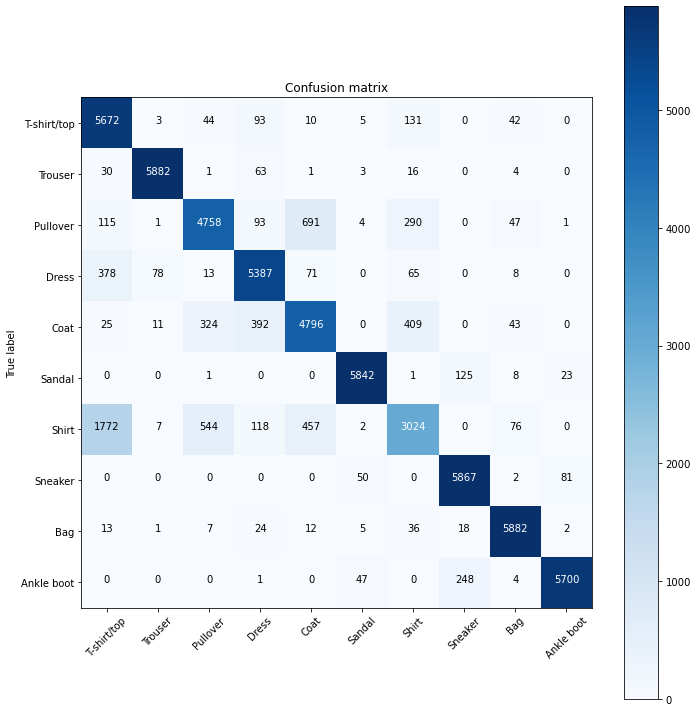

In [42]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmt, train_set.classes)

The confusion matrix has three axes:

- Prediction label (class)
- True label
- Heat map value (color)

The prediction label and true labels show us which prediction class we are dealing with. The matrix diagonal represents locations in the matrix where the prediction and the truth are the same, so this is where we want the heat map to be darker.

Any values that are not on the diagonal are incorrect predictions because the prediction and the true label don't match. To read the plot, we can use these steps:

- Choose a prediction label on the horizontal axis.
- Check the diagonal location for this label to see the total number correct.
- Check the other non-diagonal locations to see where the network is confused.

For example, the network is confusing a T-shirt/top with a shirt, but is not confusing the T-shirt/top with things like:

- Ankle boot
- Sneaker
- Sandal

If we think about it, this makes pretty good sense. As our model learns, we will see the numbers that lie outside the diagonal become smaller and smaller.